In [1]:
"""
This module contains constants representing core & auxiliary fish body parts.
"""

UPPER_LIP = 'UPPER_LIP'
EYE = 'EYE'
PECTORAL_FIN = 'PECTORAL_FIN'
DORSAL_FIN = 'DORSAL_FIN'
PELVIC_FIN = 'PELVIC_FIN'
ADIPOSE_FIN = 'ADIPOSE_FIN'
ANAL_FIN = 'ANAL_FIN'
TAIL_NOTCH = 'TAIL_NOTCH'
UPPER_PRECAUDAL_PIT = 'UPPER_PRECAUDAL_PIT'
LOWER_PRECAUDAL_PIT = 'LOWER_PRECAUDAL_PIT'
HYPURAL_PLATE = 'HYPURAL_PLATE'

core_body_parts = sorted([UPPER_LIP,
                          EYE,
                          PECTORAL_FIN,
                          DORSAL_FIN,
                          PELVIC_FIN,
                          ADIPOSE_FIN,
                          ANAL_FIN,
                          TAIL_NOTCH])

auxiliary_body_parts = sorted([UPPER_PRECAUDAL_PIT,
                               LOWER_PRECAUDAL_PIT,
                               HYPURAL_PLATE])

all_body_parts = sorted(core_body_parts + auxiliary_body_parts)

In [2]:
"""This module contains utility helper functions for the WeightEstimator class."""

from collections import namedtuple
from typing import Dict, List, Tuple
import numpy as np
import torch


CameraMetadata = namedtuple('CameraMetadata',
                            ['focal_length', 'focal_length_pixel', 'baseline_m',
                             'pixel_count_width', 'pixel_count_height', 'image_sensor_width',
                             'image_sensor_height'])


def get_left_right_keypoint_arrs(annotation: Dict[str, List[Dict]]) -> Tuple:
    """Gets numpy array of left and right keypoints given input keypoint annotation.
    Args:
        annotation: dict with keys 'leftCrop' and 'rightCrop'. Values are lists where each element
        is a dict with keys 'keypointType', 'xCrop' (num pixels from crop left edge),
        'yCrop' (num pixels from crop top edge), 'xFrame' (num pixels from full frame left edge),
        and 'yFrame' (num pixels from full frame top edge).
    Returns:
        X_left: numpy array containing left crop (xFrame, yFrame) for each key-point ordered
        alphabetically.
        X_right: same as above, but for right crop.
    """

    left_keypoints, right_keypoints = {}, {}
    for item in annotation['leftCrop']:
        body_part = item['keypointType']
        left_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    for item in annotation['rightCrop']:
        body_part = item['keypointType']
        right_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    left_keypoint_arr, right_keypoint_arr = [], []
    for body_part in core_body_parts:
        left_keypoint_arr.append(left_keypoints[body_part])
        right_keypoint_arr.append(right_keypoints[body_part])

    X_left = np.array(left_keypoint_arr)
    X_right = np.array(right_keypoint_arr)
    return X_left, X_right


def normalize_left_right_keypoint_arrs(X_left: np.ndarray, X_right: np.ndarray) -> Tuple:
    """Normalizes input left and right key-point arrays. The normalization involves (1) 2D
    translation of all keypoints such that they are centered, (2) rotation of the 2D coordiantes
    about the center such that the line passing through UPPER_LIP and fish center is horizontal.
    """

    # translate key-points, perform reflection if necessary
    upper_lip_idx = core_body_parts.index(UPPER_LIP)
    tail_notch_idx = core_body_parts.index(TAIL_NOTCH)
    if X_left[upper_lip_idx, 0] > X_left[tail_notch_idx, 0]:
        X_center = 0.5 * (np.max(X_left, axis=0) + np.min(X_left, axis=0))
        X_left_centered = X_left - X_center
        X_right_centered = X_right - X_center
    else:
        X_center = 0.5 * (np.max(X_right, axis=0) + np.min(X_right, axis=0))
        X_left_centered = X_right - X_center
        X_right_centered = X_left - X_center
        X_left_centered[:, 0] = -X_left_centered[:, 0]
        X_right_centered[:, 0] = -X_right_centered[:, 0]

    # rotate key-points
    upper_lip_x, upper_lip_y = tuple(X_left_centered[upper_lip_idx])
    theta = np.arctan(upper_lip_y / upper_lip_x)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    D = X_left_centered - X_right_centered
    X_left_rot = np.dot(X_left_centered, R)
    X_right_rot = X_left_rot - D
    return X_left_rot, X_right_rot


def convert_to_world_point_arr(X_left: np.ndarray, X_right: np.ndarray,
                               camera_metadata: CameraMetadata) -> np.ndarray:
    """Converts input left and right normalized keypoint arrays into world coordinate array."""

    y_world = camera_metadata.focal_length_pixel * camera_metadata.baseline_m / \
              (X_left[:, 0] - X_right[:, 0])

    # Note: the lines commented out below are technically the correct formula for conversion
    # x_world = X_left[:, 0] * y_world / camera_metadata.focal_length_pixel
    # z_world = -X_left[:, 1] * y_world / camera_metadata.focal_length_pixel
    x_world = ((X_left[:, 0] * camera_metadata.image_sensor_width / camera_metadata.pixel_count_width) * y_world) / (camera_metadata.focal_length)
    z_world = (-(X_left[:, 1] * camera_metadata.image_sensor_height / camera_metadata.pixel_count_height) * y_world) / (camera_metadata.focal_length)
    X_world = np.vstack([x_world, y_world, z_world]).T
    return X_world


def stabilize_keypoints(X: np.ndarray) -> np.ndarray:
    """Transforms world coordinate array so that neural network inputs are stabilized"""
    X_new = np.zeros(X.shape)
    X_new[:, 0] = 0.5 * X[:, 0] / X[:, 1]
    X_new[:, 1] = 0.5 * X[:, 2] / X[:, 1]
    X_new[:, 2] = 0.05 / X[:, 1]
    return X_new


def convert_to_nn_input(annotation: Dict[str, List[Dict]], camera_metadata: CameraMetadata) \
        -> torch.Tensor:
    """Convrts input keypoint annotation and camera metadata into neural network tensor input."""
    X_left, X_right = get_left_right_keypoint_arrs(annotation)
    X_left_norm, X_right_norm = normalize_left_right_keypoint_arrs(X_left, X_right)
    X_world = convert_to_world_point_arr(X_left_norm, X_right_norm, camera_metadata)
    X = stabilize_keypoints(X_world)
    nn_input = torch.from_numpy(np.array([X])).float()
    return nn_input

In [3]:
"""
This module contains the WeightEstimator class for estimating fish weight (g), length (mm), and
k-factor given input keypoint coordinates and camera metadata.
"""

from typing import Dict, Tuple
import torch
from torch import nn


class Network(nn.Module):
    """Network class defines neural-network architecture for both weight and k-factor estimation
    (currently both neural networks share identical architecture)."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """Run inference on input keypoint tensor."""
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x


class WeightEstimator:
    """WeightEstimator class is used to predict fish weight, k-factor, and length
    given input keypoint annotations and camera metadata."""

    def __init__(self, weight_model_f: str, kf_model_f: str) -> None:
        """Initializes class with input weight and k-factor neural-networks."""
        self.weight_model = Network()
        self.weight_model.load_state_dict(torch.load(weight_model_f))
        self.weight_model.eval()

        self.kf_model = Network()
        self.kf_model.load_state_dict(torch.load(kf_model_f))
        self.kf_model.eval()

    @staticmethod
    def _get_model_input(annotation: Dict, camera_metadata: CameraMetadata) -> torch.Tensor:
        """Generates neural-network input tensor given annotation and camera_metadata."""
        X = convert_to_nn_input(annotation, camera_metadata)
        return X

    def predict_weight(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates weight prediction given input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        weight = 1e4 * self.weight_model(X).item()
        return weight

    def predict_kf(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates k-factor prediction gievn input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        kf = self.kf_model(X).item()
        return kf

    def predict(self, annotation: Dict, camera_metadata: CameraMetadata) -> Tuple:
        """Generates weight, k-factor, and length predictions given input annotation and camera
        metadata."""
        weight = self.predict_weight(annotation, camera_metadata)
        kf = self.predict_kf(annotation, camera_metadata)
        if weight * kf > 0:
            length = (1e5 * weight / kf) ** (1.0 / 3)
        else:
            length = 0
        return weight, length, kf

In [4]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils, S3AccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [5]:
queryCache = {}

In [14]:
def getPenDF(pen):
    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.pen_id = '%s';
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])
    
    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    depths = []
    for idx, row in df.iterrows():
        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        depth = np.median([wkp[1] for wkp in wkps.values()])
        depths.append(depth)
    df['depth'] = depths
    
    return df
    
# pen1 = {
#     'pen_id': 145,
#     'start_date': '2020-12-01',
#     'end_date': '2021-02-04'
# }

pen1 = {
    'pen_id': 145,
    'start_date': '2020-01-28',
    'end_date': '2021-02-04'
}

df1 = getPenDF(pen1)

In [15]:
# pen3 = {
#     'pen_id': 145,
#     'start_date': '2021-02-05',
#     'end_date': '2021-02-23'
# }

pen3 = {
    'pen_id': 145,
    'start_date': '2021-02-05',
    'end_date': '2021-02-12'
}

df3 = getPenDF(pen3)

In [ ]:
pen1 = {
    'pen_id': 165,
    'start_date': '2020-10-25',
    'end_date': '2020-10-29'
}

df_eld = getPenDF(pen1)

In [ ]:
mask = (df_eld.akpd_score > 0.9) & (df_eld.hour >= 9) & (df_eld.hour <= 15)
df_eld2 = df_eld[mask]

plt.hist(df_eld2.estimated_weight_g, bins = 20)

In [ ]:
cm_old = df1.iloc[0].camera_metadata


In [ ]:
cm_old

In [ ]:
s3_access_utils = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

In [ ]:
def load_params(params):
    print("Loading params...")
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()

    imageSize = (4096, 3000)

    # perform rectification
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)

    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)

    print("Params loaded.")
    return left_maps, right_maps

IMAGE_WIDTH = 4096
IMAGE_HEIGHT = 3000

def get_camera_parameters(params: dict) -> Tuple:
    """Return individual camera parameters from JSON stereo parameters contents."""
    
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()
    
    imageSize = (IMAGE_WIDTH, IMAGE_HEIGHT)
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, 
                                                               distCoeffs2, imageSize, R, T, None, None, 
                                                               None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)
    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)
    
    return left_maps, right_maps, cameraMatrix1, distCoeffs1, R1, P1, cameraMatrix2, distCoeffs2, R2, P2

In [ ]:
print(cm_old['stereoParametersUrl'])

In [ ]:
import cv2

old_params_f, _, _ = s3_access_utils.download_from_url(cm_old['stereoParametersUrl'])

old_params = json.load(open(old_params_f))

old_params

In [ ]:
left_maps_m, right_maps_m, cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m, cameraMatrix2_m, distCoeffs2_m, R2_m, P2_m = get_camera_parameters(old_params)
left_maps_c, right_maps_c = right_maps_m, left_maps_m
cameraMatrix1_c, distCoeffs1_c, R1_c, P1_c = cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m
cameraMatrix2_c, distCoeffs2_c, R2_c, P2_c = cameraMatrix2_m, distCoeffs2_m, R2_m, P2_m

weight_model_f = 'nn_epoch_798_v2.pb'
kf_model_f = 'kf_model.pb'
weight_estimator2 = WeightEstimator(weight_model_f, kf_model_f)

cm_old_adj = CameraMetadata(
    focal_length=cm_old['focalLength'],
    focal_length_pixel=cm_old['focalLengthPixel'],
    baseline_m=cm_old['baseline'],
    pixel_count_width=cm_old['pixelCountWidth'],
    pixel_count_height=cm_old['pixelCountHeight'],
    image_sensor_width=cm_old['imageSensorWidth'],
    image_sensor_height=cm_old['imageSensorHeight']
)

cm_new_adj = cm_old_adj

new_keypoints = []

new_weights = []
new_lengths = []
new_k_factors = []
new_weights2 = []
new_lengths2 = []
new_k_factors2 = []

for idx, row in df1.iterrows():
    ann_m = row.annotation
    
    # un-rectify with matlab params, re-rectify with circular params
    ann_m_mp_c = {'leftCrop': [], 'rightCrop': []}
    for side in ['leftCrop', 'rightCrop']:
        for item in ann_m[side]:
            bp = item['keypointType']
            x, y = item['xFrame'], item['yFrame']
            if side == 'leftCrop':
                x_new, y_new = cv2.undistortPoints(np.array([[left_maps_m[0][y, x]]]).astype(float), 
                                    cameraMatrix1_c, distCoeffs1_c, R=R1_c, P=P1_c)[0][0]
            elif side == 'rightCrop':
                x_new, y_new = cv2.undistortPoints(np.array([[right_maps_m[0][y, x]]]).astype(float), 
                                    cameraMatrix2_c, distCoeffs2_c, R=R2_c, P=P2_c)[0][0]
            x_new, y_new = int(round(x_new)), int(round(y_new))
            ann_m_mp_c[side].append({
                'keypointType': bp,
                'xFrame': x_new,
                'yFrame': y_new
            })
#         for item in ann_m[side]:
#             bp = item['keypointType']
#             x, y = item['xFrame'], item['yFrame']
#             if side == 'leftCrop':
#                 x_new, y_new = cv2.undistortPoints(np.array([[left_maps_m[0][y, x]]]).astype(float), 
#                                     cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]
#             elif side == 'rightCrop':
#                 x_new, y_new = cv2.undistortPoints(np.array([[right_maps_m[0][y, x]]]).astype(float), 
#                                     cameraMatrix2_m, distCoeffs2_m, R=R2_m, P=P2_m)[0][0]
#             x_new, y_new = int(round(x_new)), int(round(y_new))
#             ann_m_mp_c[side].append({
#                 'keypointType': bp,
#                 'xFrame': x_new,
#                 'yFrame': y_new
#             })
    
#     ann_m_mp_c_new = {'leftCrop': [], 'rightCrop': []}
#     for side in ['leftCrop', 'rightCrop']:
#         for item in ann_m_mp_c[side]:
#             bp = item['keypointType']
#             x, y = item['xFrame'], item['yFrame']
#             maps = left_maps_c if side == 'leftCrop' else right_maps_c
#             x_new, y_new = cv2.undistortPoints(np.array([[maps[0][y, x]]]).astype(float), 
#                                 cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]
#             x_new, y_new = int(round(x_new)), int(round(y_new))
#             ann_m_mp_c_new[side].append({
#                 'keypointType': bp,
#                 'xFrame': x_new,
#                 'yFrame': y_new
#             })
    new_keypoints.append(ann_m_mp_c)
#     new_keypoints.append(ann_m_mp_c_new)
    
    new_weight, new_length, new_k_factor = weight_estimator2.predict(ann_m_mp_c, cm_old_adj)
    new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(ann_m_mp_c, cm_new_adj)
#     new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(ann_m_mp_c_new, cm_new_adj)
#     new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(row.annotation, cm_old_adj)
    
    new_weights.append(new_weight)
    new_lengths.append(new_length)
    new_k_factors.append(new_k_factor)
    new_weights2.append(new_weight2)
    new_lengths2.append(new_length2)
    new_k_factors2.append(new_k_factor2)
    
# _new_keypoints = []

# _new_weights = []
# _new_lengths = []
# _new_k_factors = []
# _new_weights2 = []
# _new_lengths2 = []
# _new_k_factors2 = []
    
# for idx, row in df2.iterrows():
#     ann_m = row.annotation
    
#     # un-rectify with matlab params, re-rectify with circular params
#     ann_m_mp_c = {'leftCrop': [], 'rightCrop': []}
#     for side in ['leftCrop', 'rightCrop']:
#         for item in ann_m[side]:
#             bp = item['keypointType']
#             x, y = item['xFrame'], item['yFrame']
#             maps = left_maps_c if side == 'leftCrop' else right_maps_c
            
#             if side == 'leftCrop':
#                 x_new, y_new = cv2.undistortPoints(np.array([[left_maps_c[0][y, x]]]).astype(float), 
#                                     cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]
#             elif side == 'rightCrop':
#                 x_new, y_new = cv2.undistortPoints(np.array([[right_maps_c[0][y, x]]]).astype(float), 
#                                     cameraMatrix2_m, distCoeffs2_m, R=R2_m, P=P2_m)[0][0]
#             x_new, y_new = int(round(x_new)), int(round(y_new))
#             ann_m_mp_c[side].append({
#                 'keypointType': bp,
#                 'xFrame': x_new,
#                 'yFrame': y_new
#             })
#     _new_keypoints.append(ann_m_mp_c)
    
#     new_weight, new_length, new_k_factor = weight_estimator2.predict(ann_m_mp_c, cm_old_adj)
#     new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(ann_m_mp_c, cm_new_adj)
    
#     _new_weights.append(new_weight)
#     _new_lengths.append(new_length)
#     _new_k_factors.append(new_k_factor)
#     _new_weights2.append(new_weight2)
#     _new_lengths2.append(new_length2)
#     _new_k_factors2.append(new_k_factor2)

In [ ]:
df1['new_keypoints'] = new_keypoints
df1['new_weights'] = new_weights
df1['new_lengths'] = new_lengths
df1['new_k_factors'] = new_k_factors
df1['new_weights2'] = new_weights2
df1['new_lengths2'] = new_lengths2
df1['new_k_factors2'] = new_k_factors2

# df2['new_keypoints'] = _new_keypoints
# df2['new_weights'] = _new_weights
# df2['new_lengths'] = _new_lengths
# df2['new_k_factors'] = _new_k_factors
# df2['new_weights2'] = _new_weights2
# df2['new_lengths2'] = _new_lengths2
# df2['new_k_factors2'] = _new_k_factors2

In [ ]:
dates = sorted(list(set(list(df1.date))))
dates2 = sorted(list(set(list(df3.date))))

In [ ]:
old_weight = []
new_weight = []

for date in dates:
    mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date == date)

    df2 = df1[mask]
    print(date, len(df2))
    
    old_weight.append(np.mean(df2['estimated_weight_g']))
    new_weight.append(np.mean(df2['new_weights']))

for date in dates2:
    mask = (df3.akpd_score > 0.95) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date == date)

    df2 = df3[mask]
    print(date, len(df2))
    old_weight.append(np.mean(df2['estimated_weight_g']))
    new_weight.append(np.mean(df2['estimated_weight_g']))

In [16]:
mask = (df1.akpd_score > 0.9) & (df1.hour >= 9) & (df1.hour <= 15)
df2 = df1[mask]

mask = (df3.akpd_score > 0.9) & (df3.hour >= 9) & (df3.hour <= 15) #& (df3.date >= '2021-02-16')
df4 = df3[mask]

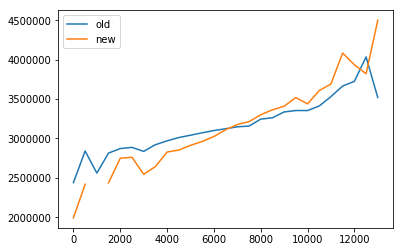

In [11]:
weights = np.arange(0, 14000, 500)
depths_old = []
depths_new = []

for weight in weights:
    mask = (df2['estimated_weight_g'] > weight) & (df2['estimated_weight_g'] < weight + 500)
    depths_old.append(np.mean([ x['left_crop_metadata']['crop_area'] for i, x in df2[mask].iterrows() ]))
    mask = (df4['estimated_weight_g'] > weight) & (df4['estimated_weight_g'] < weight + 500)
    depths_new.append(np.mean([ x['left_crop_metadata']['crop_area'] for i, x in df4[mask].iterrows() ]))

plt.plot(weights, depths_old, label = 'old')
plt.plot(weights, depths_new, label = 'new')
plt.legend()

In [ ]:
mask = (df1.akpd_score > 0.9) & (df1.hour >= 9) & (df1.hour <= 15)
df2 = df1[mask]

mask = (df3.akpd_score > 0.9) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date >= '2021-02-16')
df4 = df3[mask]

weights = np.arange(0, 14000, 500)
depths_old = []
depths_new = []

for weight in weights:
    mask = (df2['estimated_weight_g'] > weight) & (df2['estimated_weight_g'] < weight + 500)
    depths_old.append(np.mean(df2[mask]['depth']))
    mask = (df4['estimated_weight_g'] > weight) & (df4['estimated_weight_g'] < weight + 500)
    depths_new.append(np.mean(df4[mask]['depth']))

plt.plot(weights, depths_old, label = 'old')
plt.plot(weights, depths_new, label = 'new')
plt.legend()

In [ ]:
sum(df2['estimated_weight_g'] < 3000) / len(df2)

In [ ]:
mask = (df1.akpd_score > 0) & (df1.hour >= 9) & (df1.hour <= 15)
df2 = df1[mask]

mask = (df3.akpd_score > 0) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date >= '2021-02-16')
df4 = df3[mask]

depths = np.arange(0, 3, 0.1)
weights_old = []
weights_new = []

for depth in depths:
    mask = (df2['depth'] > depth) & (df2['depth'] < depth + 0.1)
    weights_old.append(np.mean([ x['left_crop_metadata']['crop_area'] for i, x in df2[mask].iterrows() ]))
    mask = (df4['depth'] > depth) & (df4['depth'] < depth + 0.1)
    weights_new.append(np.mean([ x['left_crop_metadata']['crop_area'] for i, x in df4[mask].iterrows() ]))

plt.plot(depths, weights_old, label = 'old')
plt.plot(depths, weights_new, label = 'new')
plt.legend()

In [ ]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date > '2021-02-02') #(df1.date > '2021-01-20') & (df1.date < '2021-01-28')
df2 = df1[mask]

mask = (df3.akpd_score > 0.95) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date < '2021-02-07') #(df3.date > '2021-02-12') & (df3.date < '2021-02-20')
df4 = df3[mask]

depths = np.arange(0, 3, 0.1)
weights_old = []
weights_new = []

for depth in depths:
    mask = (df2['depth'] > depth) & (df2['depth'] < depth + 0.1)
    weights_old.append(np.median(df2[mask]['estimated_weight_g']))
    mask = (df4['depth'] > depth) & (df4['depth'] < depth + 0.1)
    weights_new.append(np.median(df4[mask]['estimated_weight_g']))

plt.plot(depths, weights_old, label = 'old')
plt.plot(depths, weights_new, label = 'new')
plt.legend()

for depth in depths:
    weight1 = np.mean(df2[(df2.depth < depth)].estimated_weight_g)
    weight2 = np.mean(df4[(df4.depth < depth)].estimated_weight_g)
    print('%0.2f %0.2f %0.2f %0.2f' % (depth, np.abs(weight1 - weight2) / weight1 * 100, weight1, weight2))
    
    

In [ ]:
plt.hist(df2.depth, bins = 20, alpha = 0.5, density = True, color = 'red')
plt.hist(df4.depth, bins = 20, alpha = 0.5, density = True, color = 'blue')

print(np.mean(df2.depth), np.mean(df2.estimated_weight_g))
print(np.mean(df4.depth), np.mean(df4.estimated_weight_g))

(array([6.07426625e-07, 0.00000000e+00, 1.56195418e-06, 4.51231207e-06,
        8.24364706e-06, 1.72682712e-05, 3.84414278e-05, 7.94861127e-05,
        1.32158679e-04, 2.06091176e-04, 2.50520095e-04, 2.35768306e-04,
        1.88389029e-04, 1.37191642e-04, 9.34569250e-05, 5.73584285e-05,
        3.39291158e-05, 1.46650142e-05, 3.81811022e-06, 8.67752322e-07]),
 array([  158.57391059,   823.31927493,  1488.06463927,  2152.81000361,
         2817.55536795,  3482.30073228,  4147.04609662,  4811.79146096,
         5476.5368253 ,  6141.28218964,  6806.02755398,  7470.77291831,
         8135.51828265,  8800.26364699,  9465.00901133, 10129.75437567,
        10794.49974   , 11459.24510434, 12123.99046868, 12788.73583302,
        13453.48119736]),
 <a list of 20 Patch objects>)

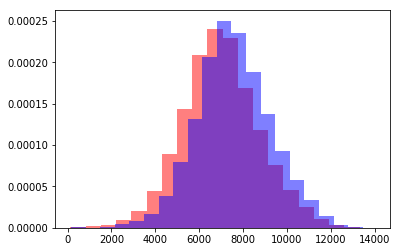

In [12]:
plt.hist(df2.estimated_weight_g, bins = 20, alpha = 0.5, density = True, color = 'red')
plt.hist(df4.estimated_weight_g, bins = 20, alpha = 0.5, density = True, color = 'blue')

(array([1.87743782e-02, 7.91205939e-02, 2.70887457e-01, 4.43879942e-01,
        6.81241724e-01, 1.01918053e+00, 1.28738594e+00, 1.54888620e+00,
        1.71517355e+00, 1.70980945e+00, 1.31957058e+00, 9.88336911e-01,
        5.73959563e-01, 3.16482376e-01, 1.38125783e-01, 7.64385399e-02,
        4.02308105e-02, 2.01154052e-02, 4.02308105e-03, 1.34102702e-03]),
 array([0.74351311, 0.82512601, 0.90673892, 0.98835183, 1.06996473,
        1.15157764, 1.23319055, 1.31480346, 1.39641636, 1.47802927,
        1.55964218, 1.64125508, 1.72286799, 1.8044809 , 1.88609381,
        1.96770671, 2.04931962, 2.13093253, 2.21254543, 2.29415834,
        2.37577125]),
 <a list of 20 Patch objects>)

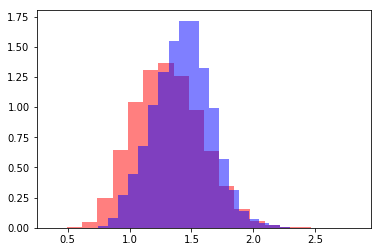

In [18]:
plt.hist(df2.depth, bins = 20, alpha = 0.5, density = True, color = 'red')
plt.hist(df4.depth, bins = 20, alpha = 0.5, density = True, color = 'blue')

In [ ]:
df2.left_crop_metadata.iloc[0]

In [ ]:
old_depth = []
new_depth = []

old_ca = []
new_ca = []

old_weight = []
new_weight = []
_weight = []

for date in dates:
    mask = (df1.akpd_score > 0.9) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date == date) & (df1.estimated_weight_g > 6500)
#     mask = (df1.date == date)

    df2 = df1[mask]
#     print(date, len(df2))
    
    mean_green_luminance = [x['left_crop_metadata']['crop_area'] for i, x in df2.iterrows()]
    
    old_depth.append(np.mean(df2['depth']))
    new_depth.append(np.mean(df2['depth']))
    old_ca.append(np.mean(df2['estimated_weight_g']))
    new_ca.append(np.mean(df2['estimated_weight_g']))
    old_weight.append(np.median(mean_green_luminance))
    new_weight.append(np.median(mean_green_luminance))

for date in dates2:
    mask = (df3.akpd_score > 0.9) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date == date) & (df3.estimated_weight_g > 6500)
#     mask = (df3.date == date)

    df2 = df3[mask]
    
    mean_green_luminance = [x['left_crop_metadata']['crop_area'] for i, x in df2.iterrows()]
#     print(date, len(df2))
    old_depth.append(np.mean(df2['depth']))
    old_ca.append(np.mean(df2['estimated_weight_g']))
    old_weight.append(np.median(mean_green_luminance))
    _weight.append(np.median(mean_green_luminance))

In [ ]:
(dates + dates2)[38]

In [ ]:
plt.plot(old_weight)
plt.plot(new_weight)

In [ ]:
plt.plot(old_ca)
plt.plot(new_ca)

In [ ]:
plt.plot(old_ca)
plt.plot(new_ca)

In [ ]:
mask = (df3.akpd_score > 0.9) & (df3.hour >= 9) & (df3.hour <= 15)
plt.hist(df3[mask].estimated_weight_g, bins = 20)
print(np.mean(df3[mask].estimated_weight_g))

In [ ]:
plt.plot(np.array(old_weight) / np.array(old_ca))
plt.plot(np.array(new_weight) / np.array(new_ca))

In [ ]:
plt.plot(old_depth)
plt.plot(new_depth)
plt.axhline(1.5)
plt.axhline(1.55)

In [ ]:
np.mean(_weight) / np.mean(new_weight)

In [ ]:
plt.plot(old_weight, color = 'red')
plt.plot(new_weight)

In [ ]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date == '2021-02-02')

df2 = df1[mask]

mask = (df3.akpd_score > 0.95) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date == '2021-02-07')

df4 = df3[mask]

plt.hist(df2['estimated_weight_g'], density = True, alpha = 0.5, color = 'red', bins = 20)
plt.hist(df4['estimated_weight_g'], density = True, alpha = 0.5, color = 'blue', bins = 20)

In [ ]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date == '2021-02-02')

df2 = df1[mask]

mask = (df3.akpd_score > 0.95) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date == '2021-02-06')

df4 = df3[mask]

plt.hist(df2['new_weights'], density = True, alpha = 0.5, color = 'red', bins = 20)
plt.hist(df4['estimated_weight_g'], density = True, alpha = 0.5, color = 'blue', bins = 20)

In [ ]:
df2.iloc[0]

In [ ]:
df4.iloc[0]

In [ ]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date == '2021-01-24')

df2 = df1[mask]

mean_green_luminance = [x['left_crop_metadata']['mean_green_luminance'] for i, x in df2.iterrows()]
depth = df2['depth']

# plt.hist(mean_green_luminance)
plt.hist(depth)

In [ ]:
mask = (df3.akpd_score > 0.95) & (df3.hour >= 9) & (df3.hour <= 15) & (df3.date == '2021-02-14')

df4 = df3[mask]

mean_green_luminance = [x['left_crop_metadata']['mean_green_luminance'] for i, x in df4.iterrows()]
depth = df4['depth']

# plt.hist(mean_green_luminance)
plt.hist(depth)

In [ ]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 9) & (df1.hour <= 15) & (df1.date >= '2021-02-01') & (df1.date < '2021-02-02')

df2 = df1[mask]

In [ ]:
np.mean(df2['new_weights'])

In [ ]:
np.mean(df2['estimated_weight_g'])

In [ ]:
tdf = df1

from report_generation.report_generator import generate_ts_data, SamplingFilter

sampling_filter = SamplingFilter(
    start_hour=7,
    end_hour=15,
    kf_cutoff=0.0,
    akpd_score_cutoff=0.01
)

pm_base = gen_pm_base(tdf, sampling_filter)

In [ ]:
def generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding):
    last_feeding_date = gt_metadata['last_feeding_date']
    date = add_days(last_feeding_date, days_post_feeding)
    weights, _ = generate_smart_individual_values(pm_base, date, max_day_diff, True, apply_growth_rate, 0.9)
    return weights

weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)

In [ ]:
plt.scatter(df1[df1.akpd_score > 0.01].estimated_weight_g, df1[df1.akpd_score > 0.01].new_weights)

In [ ]:
plt.scatter(df1[df1.akpd_score > 0.01].estimated_weight_g, df1[df1.akpd_score > 0.01].new_weights2)

In [ ]:
np.mean(df1[df1.akpd_score > 0.01].estimated_weight_g), np.mean(df1[df1.akpd_score > 0.01].new_weights), np.mean(df1[df1.akpd_score > 0.01].new_weights2)

In [ ]:
1 - 7387/8225
# np.mean(df2[df2.akpd_score > 0.01].estimated_weight_g), np.mean(df2[df2.akpd_score > 0.01].new_weights), np.mean(df2[df2.akpd_score > 0.01].new_weights2)

In [ ]:
idx = -1

df1['diff'] = df1.estimated_weight_g - df1.new_weights
df4 = df1[df1.akpd_score > 0.01].sort_values(['diff'])

print(df4.iloc[idx]['diff'])

ann1 = df4.iloc[idx].annotation

new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(ann1, cm_old_adj)
print(new_weight2)

In [ ]:

ann2 = df4.iloc[idx].new_keypoints

new_weight2, new_length2, new_k_factor2 = weight_estimator2.predict(ann2, cm_old_adj)
print(new_weight2)

In [ ]:
ann1['rightCrop']

In [ ]:
ann2['rightCrop']

In [ ]:
plt.scatter(df1[df1.akpd_score > 0.01].estimated_weight_g, df1[df1.akpd_score > 0.01].new_weights2)

In [ ]:
print(df1.iloc[0].left_crop_url_adjusted)
print(df1.iloc[0].left_crop_url)

df1.iloc[0]

In [ ]:
 ''

In [ ]:
left_crop_url_adjusteds = []

for index, row in df1.iterrows():
    left_crop_url_adjusteds.append(row.left_crop_url.replace('production', 'dev'))
    
df1['left_crop_url_adjusted'] = left_crop_url_adjusteds

In [ ]:
rows = df1[df1.left_crop_url == 'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=62/pen-id=151/date=2020-10-05/hour=22/at=2020-10-05T22:30:03.540743000Z/left_frame_crop_844_1661_4076_2867.jpg']


# for index, row in rows.iterrows():
#     rows.loc[index, 'left_crop_url_adjusted'] = row.left_crop_url.replace('production', 'dev')
# df1.update(rows)

row = df1[df1.left_crop_url == 'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=62/pen-id=151/date=2020-10-12/hour=10/at=2020-10-12T10:35:54.611253000Z/left_frame_crop_0_378_3292_1601.jpg'].iloc[0]

print(row.left_crop_url)
print(row.left_crop_url_adjusted)

In [ ]:
df2['left_crop_url_adjusted'] = df2['left_crop_url']

In [ ]:
df3 = pd.merge(df1, df2, on='left_crop_url_adjusted')
df3['diff'] = df3.new_weights2_x - df3.estimated_weight_g_y
df3_f = df3[(df3.akpd_score_x > 0.95) & (df3.akpd_score_y > 0.95)]
len(df3_f)

In [ ]:
plt.scatter(df3_f.estimated_weight_g_y, df3_f.new_weights_y)
plt.plot(df3_f.estimated_weight_g_y, df3_f.estimated_weight_g_y, color = 'red')

np.mean(df3_f.estimated_weight_g_y), np.mean(df3_f.new_weights_y), np.mean(df3_f.new_weights2_y)

In [ ]:
plt.scatter(df3_f.estimated_weight_g_x, df3_f.estimated_weight_g_y)


In [ ]:
plt.scatter(df3_f.estimated_weight_g_x, df3_f.new_weights_x)
plt.plot(df3_f.estimated_weight_g_x, df3_f.estimated_weight_g_x, color = 'red')

np.mean(df3_f.estimated_weight_g_x), np.mean(df3_f.new_weights_x), np.mean(df3_f.new_weights2_x)

In [ ]:
plt.scatter(df3_f.new_weights2_x, df3_f.estimated_weight_g_y)
plt.plot(df3_f.new_weights2_x, df3_f.new_weights2_x, color = 'red')

np.mean(df3_f.estimated_weight_g_y)

In [ ]:
plt.scatter(df3_f.new_weights2_y, df3_f.estimated_weight_g_x)
plt.plot(df3_f.new_weights2_y, df3_f.new_weights2_y, color = 'red')

np.mean(df3_f.estimated_weight_g_x)

In [ ]:
# df1_f['diff'] = df1_f.new_weights2 - df2_f.estimated_weight_g

df4 = df3_f.sort_values(['diff'])

In [ ]:
print(df4.iloc[0].left_crop_url_adjusted)
print(df4.iloc[0].left_crop_url_x)
print(df4.iloc[0].left_crop_url_y)

df4.iloc[0]

In [ ]:
# weight_model_f = 'weight_model.pb'
weight_model_f = 'nn_epoch_798_v2.pb'
kf_model_f = 'kf_model.pb'
weight_estimator2 = WeightEstimator(weight_model_f, kf_model_f)

# weight_model_f = 'weight_model.pb'
# kf_model_f = 'kf_model.pb'
# weight_estimator3 = WeightEstimator(weight_model_f, kf_model_f)

# weight_model_f = 'weight_model_synthetic_data.pb'
# kf_model_f = 'kf_model.pb'
# weight_estimator4 = WeightEstimator(weight_model_f, kf_model_f)

weights2 = []
weights3 = []
weights4 = []
weights5 = []



for index, row in df1.iterrows():
    ann, camera_metadata = row.annotation, row.camera_metadata
    
    df1.loc[index, 'left_crop_url_adjusted'] = row.left_crop_url.replace('production', 'dev')
    
    cm2 = CameraMetadata(
        focal_length=cm_new['focalLength'],
        focal_length_pixel=camera_metadata['focalLengthPixel'],
        baseline_m=cm_new['baseline'],
        pixel_count_width=camera_metadata['pixelCountWidth'],
        pixel_count_height=camera_metadata['pixelCountHeight'],
        image_sensor_width=camera_metadata['imageSensorWidth'],
        image_sensor_height=camera_metadata['imageSensorHeight']
    )
    
    cm3 = CameraMetadata(
        focal_length=camera_metadata['focalLength'],
        focal_length_pixel=cm_new['focalLengthPixel'],
        baseline_m=cm_new['baseline'],
        pixel_count_width=camera_metadata['pixelCountWidth'],
        pixel_count_height=camera_metadata['pixelCountHeight'],
        image_sensor_width=camera_metadata['imageSensorWidth'],
        image_sensor_height=camera_metadata['imageSensorHeight']
    )
    
    cm4 = CameraMetadata(
        focal_length=cm_new['focalLength'],
        focal_length_pixel=cm_new['focalLengthPixel'],
        baseline_m=camera_metadata['baseline'],
        pixel_count_width=camera_metadata['pixelCountWidth'],
        pixel_count_height=camera_metadata['pixelCountHeight'],
        image_sensor_width=camera_metadata['imageSensorWidth'],
        image_sensor_height=camera_metadata['imageSensorHeight']
    )
    
    cm5 = CameraMetadata(
        focal_length=cm_new['focalLength'],
        focal_length_pixel=cm_new['focalLengthPixel'],
        baseline_m=cm_new['baseline'],
        pixel_count_width=camera_metadata['pixelCountWidth'],
        pixel_count_height=camera_metadata['pixelCountHeight'],
        image_sensor_width=camera_metadata['imageSensorWidth'],
        image_sensor_height=camera_metadata['imageSensorHeight']
    )
    
    weight2, length, kf = weight_estimator2.predict(row.annotation, cm2)
    weight3, length, kf = weight_estimator2.predict(row.annotation, cm3)
    weight4, length, kf = weight_estimator2.predict(row.annotation, cm4)
    weight5, length, kf = weight_estimator2.predict(row.annotation, cm5)
    
    weights2.append(weight2)
    weights3.append(weight3)
    weights4.append(weight4)
    weights5.append(weight5)
    
df1['weights2'] = weights2
df1['weights3'] = weights3
df1['weights4'] = weights4
df1['weights5'] = weights5

In [ ]:
df2['left_crop_url_adjusted'] = df2.left_crop_url

In [ ]:
df3 = pd.merge(df1, df2, on='left_crop_url_adjusted')

In [ ]:
df3

In [ ]:
df1_filtered = df1[(df1.akpd_score > 0.01) & (df2.akpd_score > 0.01)]
df2_filtered = df2[(df1.akpd_score > 0.01) & (df2.akpd_score > 0.01)]

df1_filtered[['estimated_weight_g', 'weights2', 'weights3', 'weights4', 'akpd_score']].head(100)

In [ ]:
plt.hist(df1_filtered.weights2 - df1_filtered.estimated_weight_g)
plt.title('focalLength + baseline after - before')
np.mean(df1_filtered.weights2 - df1_filtered.estimated_weight_g)

In [ ]:
plt.hist(df1_filtered.weights3 - df1_filtered.estimated_weight_g)
plt.title('focalLengthPixel + baseline after - before')
np.mean(df1_filtered.weights3 - df1_filtered.estimated_weight_g)

In [ ]:
plt.hist(df1_filtered.weights4 - df1_filtered.estimated_weight_g)
plt.title('focaLength + focalLengthPixel after - before')
np.mean(df1_filtered.weights4 - df1_filtered.estimated_weight_g)

In [ ]:
plt.hist(df1_filtered.weights5 - df1_filtered.estimated_weight_g)
plt.title('focaLength + focalLengthPixel + baseline after - before')
np.mean(df1_filtered.weights5 - df1_filtered.estimated_weight_g)

In [ ]:
counts, bins, _ = plt.hist(df1_filtered.estimated_weight_g, bins = 40, alpha = 0.5, color = 'red', density = True)
plt.hist(df1_filtered.weights2, bins = bins, alpha = 0.5, color = 'blue', density = True)

In [ ]:
df1.iloc[0].annotation

In [ ]:
df2.iloc[0].annotation

In [ ]:
idx = 1

df4.iloc[idx]

In [ ]:
df2_filtered.iloc[idx]

In [ ]:
df4.iloc[1].annotation['leftCrop']

In [ ]:
df2_filtered.iloc[1].annotation['leftCrop']

In [ ]:
left1 = df1_filtered.iloc[5].annotation['leftCrop']
left2 = df2_filtered.iloc[5].annotation['leftCrop']

tail_notch_index = 0
upper_lip_index = 2

x1, y1 = left1[tail_notch_index]['xFrame'], left1[tail_notch_index]['yFrame']
x2, y2 = left2[tail_notch_index]['xFrame'], left2[tail_notch_index]['yFrame']
    
a1, b1 = left1[upper_lip_index]['xFrame'], left1[upper_lip_index]['yFrame']
a2, b2 = left2[upper_lip_index]['xFrame'], left2[upper_lip_index]['yFrame']
    
print(x1, y1, np.sqrt((x1 - x2) ** 2  + (y1 - y2) ** 2))
print(x2, y2)
    
print()

print(a1, b1, np.sqrt((a1 - a2) ** 2  + (b1 - b2) ** 2))
print(a2, b2)
    
print()
    
print(x1 - a1, y1 - b1, np.sqrt((x1 - a1) ** 2  + (y1 - b1) ** 2))
print(x2 - a2, y2 - b2, np.sqrt((x2 - a2) ** 2  + (y2 - b2) ** 2))

In [ ]:


def display_crops_l(left_image_f, right_image_f, left_ann, right_ann, overlay_keypoints=True, show_labels=False):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    left_image = plt.imread(left_image_f)
    right_image = plt.imread(right_image_f)
    axes[0].imshow(left_image)
    axes[1].imshow(right_image)
    left_ann, right_ann = left_ann['leftCrop'], right_ann['leftCrop']
#     left_ann, right_ann = left_ann['rightCrop'], right_ann['rightCrop']
    left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in left_ann}
    right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in right_ann}
    if overlay_keypoints:
        for bp, kp in left_keypoints.items():
            axes[0].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in right_keypoints.items():
            axes[1].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='red')
    plt.show()

In [ ]:


def display_crops(left_image_f, right_image_f, left_ann, right_ann, overlay_keypoints=True, show_labels=False):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    left_image = plt.imread(left_image_f)
    right_image = plt.imread(right_image_f)
    axes[0].imshow(left_image)
    axes[1].imshow(right_image)
#     left_ann, right_ann = left_ann['leftCrop'], right_ann['leftCrop']
    left_ann, right_ann = left_ann['rightCrop'], right_ann['rightCrop']
    left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in left_ann}
    right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in right_ann}
    if overlay_keypoints:
        for bp, kp in left_keypoints.items():
            axes[0].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in right_keypoints.items():
            axes[1].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='red')
    plt.show()

In [ ]:
print(df4.iloc[0].left_crop_url_x)
print(df4.iloc[0].left_crop_url_y)
df4.iloc[0]

In [ ]:
idx = 0

from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df4.iloc[idx]
row2 = df4.iloc[idx]
left_crop_url, right_crop_url = row1.left_crop_url_x, row2.left_crop_url_y
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation_x
right_ann = row2.annotation_y
display_crops_l(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df4.iloc[idx]
row2 = df4.iloc[idx]
left_crop_url, right_crop_url = row1.right_crop_url_x, row2.right_crop_url_y
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation_x
right_ann = row2.annotation_y
display_crops(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
print(df4.iloc[idx].left_crop_url_adjusted)
print(df4.iloc[idx].left_crop_url_x)
print(df4.iloc[idx].left_crop_url_y)
print(df4.iloc[idx].new_weights2)
print(df4.iloc[idx].estimated_weight_g_y)
print(df4.iloc[idx].akpd_score_x)
print(df4.iloc[idx].akpd_score_y)

df4.iloc[idx]

In [ ]:
from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df4.iloc[1]
row2 = df4.iloc[1]
left_crop_url, right_crop_url = row1.left_crop_url_x, row2.left_crop_url_y
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation_x
right_ann = row2.annotation_y
display_crops(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df1_filtered.iloc[1]
row2 = df2_filtered.iloc[1]

print(row1.akpd_score, row2.akpd_score)

left_crop_url, right_crop_url = row1.right_crop_url, row2.right_crop_url
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation
right_ann = row2.annotation
display_crops(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df1_filtered.iloc[6]
row2 = df2_filtered.iloc[6]
left_crop_url, right_crop_url = row1.left_crop_url, row2.left_crop_url
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation
right_ann = row2.annotation
display_crops(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
from research.utils.data_access_utils import S3AccessUtils
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
row1 = df1_filtered.iloc[6]
row2 = df2_filtered.iloc[6]

print(row1.akpd_score, row2.akpd_score)

left_crop_url, right_crop_url = row1.right_crop_url, row2.right_crop_url
left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
left_ann = row1.annotation
right_ann = row2.annotation
display_crops(left_crop_f, right_crop_f, left_ann, right_ann)

In [ ]:
df3

In [ ]:
df4 = df3[df3.akpd_score_x > 0.99]
plt.scatter(df4.estimated_weight_g_x, df4.estimated_weight_g_y)



In [ ]:
for bucket in np.arange(0, 10000, 1000):
    df5 = df4[(df4.estimated_weight_g_x > bucket)& (df4.estimated_weight_g_x < (bucket + 1000))]
    
#     print(np.mean(df5.estimated_weight_g_x), np.mean(df5.estimated_weight_g_y), np.mean(df5.estimated_weight_g_y) / np.mean(df5.estimated_weight_g_x))
    print('%i %i %i, %0.2f, %0.2f' % (len(df5.estimated_weight_g_x), np.sum(df5.estimated_weight_g_y < bucket), np.sum(df5.estimated_weight_g_y > (bucket + 1000)), np.sum(df5.estimated_weight_g_y < bucket) / len(df5.estimated_weight_g_x), np.sum(df5.estimated_weight_g_y > (bucket + 1000)) / len(df5.estimated_weight_g_x)))
    
    
    
    

In [1]:
df1

NameError: name 'df1' is not defined